<a href="https://colab.research.google.com/github/Pradeep1070/Movie-recommendation-system/blob/main/NCF_Movie_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Colab Notebooks/Projects/MovieLens_Rec_system/data/'

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

# loading data and initial exploration

In [ ]:
ratings = pd.read_csv(path+'rating.csv', parse_dates=['timestamp'])
movies = pd.read_csv(path+'movie.csv')
# tag = pd.read_csv('/kaggle/input/movielens-20m-dataset/tag.csv', parse_dates=['timestamp'])
# link = pd.read_csv('/kaggle/input/movielens-20m-dataset/link.csv')
# genome_scores = pd.read_csv('/kaggle/input/movielens-20m-dataset/genome_scores.csv')
# genome_tags = pd.read_csv('/kaggle/input/movielens-20m-dataset/genome_tags.csv')

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [ ]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

No NaN or Null values in the ratings table

In [ ]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_ratings = len(ratings)

print('unique no of users: ',n_users)
print('unique no of movies: ',n_movies)
print('no of max possible ratings: ',n_users*n_movies)
print('no of ratings: ',n_ratings)
print('ratings availability ratio: ',(n_users*n_movies)/n_ratings)

unique no of users:  138493
unique no of movies:  26744
no of max possible ratings:  3703856792
no of ratings:  20000263
ratings availability ratio:  185.19040434618285


ratings availability ratio = 185.19

denotes the sparcity of the corresponding utility matrix

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [ ]:
ratings_merged = pd.merge(ratings, movies, on='movieId')
ratings_merged.head()

,userId,movieId,rating,timestamp,title,genres
0,1,2,3.5,2005-04-02 23:53:47,Jumanji (1995),"[Adventure, Children, Fantasy]"
1,5,2,3.0,1996-12-25 15:26:09,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,13,2,3.0,1996-11-27 08:19:02,Jumanji (1995),"[Adventure, Children, Fantasy]"
3,29,2,3.0,1996-06-23 20:36:14,Jumanji (1995),"[Adventure, Children, Fantasy]"
4,34,2,3.0,1996-10-28 13:29:44,Jumanji (1995),"[Adventure, Children, Fantasy]"


# **EDA**

Most frequently rated movies

In [ ]:
ratings_merged['title'].value_counts()[0:10]

title
Pulp Fiction (1994)                          67310
Forrest Gump (1994)                          66172
Shawshank Redemption, The (1994)             63366
Silence of the Lambs, The (1991)             63299
Jurassic Park (1993)                         59715
Star Wars: Episode IV - A New Hope (1977)    54502
Braveheart (1995)                            53769
Terminator 2: Judgment Day (1991)            52244
Matrix, The (1999)                           51334
Schindler's List (1993)                      50054
Name: count, dtype: int64

Distribution of movie ratings (mean rating)

In [ ]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")

user_mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(user_mean_ratings.mean(),2)}.")

Mean global rating: 3.53.
Mean rating per user: 3.63.


In [ ]:
mean_ratings = pd.DataFrame(ratings_merged.groupby('title')['rating'].agg(['mean','count'])).rename(columns={'mean': 'mean_rating', 'count': 'freq'})
mean_ratings.head()

,mean_rating,freq
title,,
#chicagoGirl: The Social Network Takes on a Dictator (2013),3.666667,3
$ (Dollars) (1971),2.833333,24
$5 a Day (2008),2.871795,39
$9.99 (2008),3.009091,55
$ellebrity (Sellebrity) (2012),2.000000,2


<Axes: xlabel='freq', ylabel='Count'>

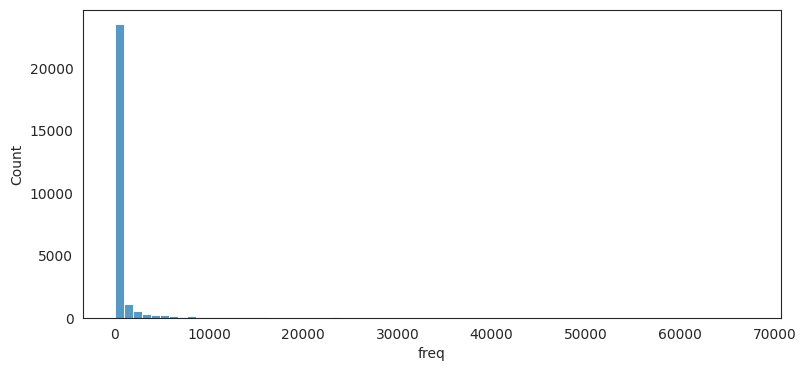

In [ ]:
plt.figure(figsize=(9,4))
sns.histplot(mean_ratings['freq'], bins=70)

<Axes: xlabel='mean_rating', ylabel='Count'>

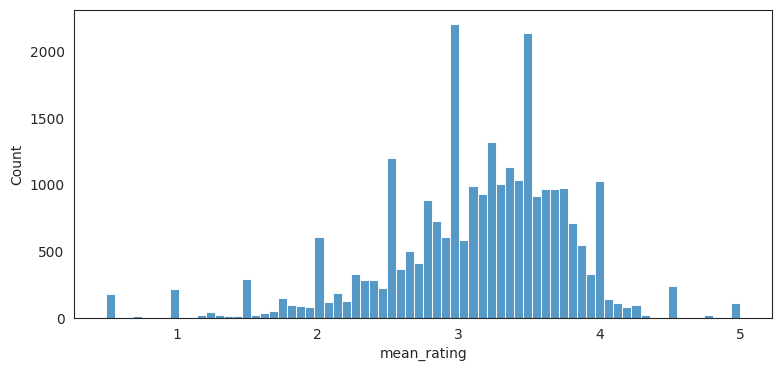

In [ ]:
plt.figure(figsize=(9,4))
sns.histplot(mean_ratings['mean_rating'], bins=70)

average ratings per movie aproximates a normal distribution with mode and mean around 3.5

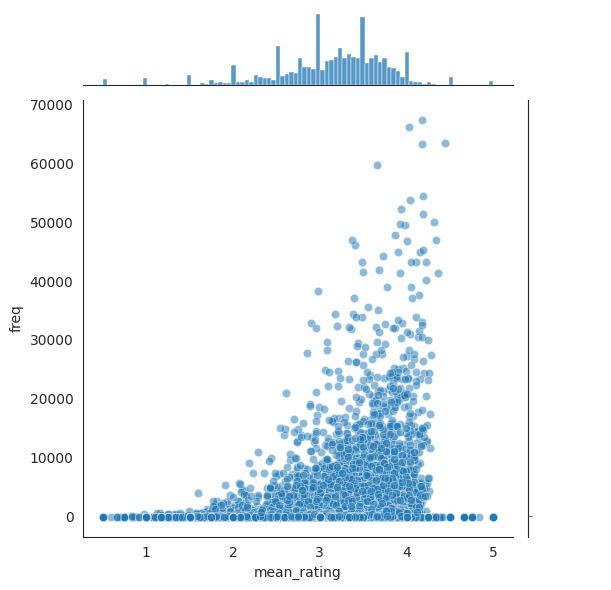

In [ ]:
sns.jointplot(x='mean_rating',y='freq',data=mean_ratings,alpha=0.5)

**Bayesian Avg**

lowest and highest average rating

In [ ]:

mean_ratings.loc[mean_ratings['mean_rating'].idxmin()]

mean_rating    0.5
freq           1.0
Name: 13 Fighting Men (1960), dtype: float64

In [ ]:
mean_ratings.loc[mean_ratings['mean_rating'].idxmax()]

mean_rating    5.0
freq           1.0
Name: 1971 (2014), dtype: float64

highest and lowest rated movies have inadequate no of ratings. hence using bayesian average is a better approach

In [ ]:
mstats = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
mstats.head()

,count,mean
movieId,,
1,49695,3.921240
2,22243,3.211977
3,12735,3.151040
4,2756,2.861393
5,12161,3.064592


In [ ]:
C = mstats['count'].mean()
m = mstats['mean'].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

#bayesian average function
def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return round(bayesian_avg, 3)

Average number of ratings for a given movie: 747.84
Average rating for a given movie: 3.13


In [ ]:
#apply bayesian_avg to all movies
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
mstats = mstats.merge(bayesian_avg_ratings, on='movieId')

mstats = mstats.merge(movies[['movieId', 'title']])

In [ ]:
mstats.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title
315,318,63366,4.446990,4.432,"Shawshank Redemption, The (1994)"
843,858,41355,4.364732,4.343,"Godfather, The (1972)"
49,50,47006,4.334372,4.316,"Usual Suspects, The (1995)"
523,527,50054,4.310175,4.293,Schindler's List (1993)
1195,1221,27398,4.275641,4.245,"Godfather: Part II, The (1974)"


above movies are generally regarded as the best movies of all time. bayesian average is a better way to interpret the ratings

**A Brief look at the genres**

In [ ]:
from collections import Counter

gen_f = Counter(g for genres in movies['genres'] for g in genres)
print(f"There are {len(gen_f)} genres.")
gen_f

There are 20 genres.


Counter({'Adventure': 2329,
         'Animation': 1027,
         'Children': 1139,
         'Comedy': 8374,
         'Fantasy': 1412,
         'Romance': 4127,
         'Drama': 13344,
         'Action': 3520,
         'Crime': 2939,
         'Thriller': 4178,
         'Horror': 2611,
         'Mystery': 1514,
         'Sci-Fi': 1743,
         'IMAX': 196,
         'Documentary': 2471,
         'War': 1194,
         'Musical': 1036,
         'Western': 676,
         'Film-Noir': 330,
         '(no genres listed)': 246})

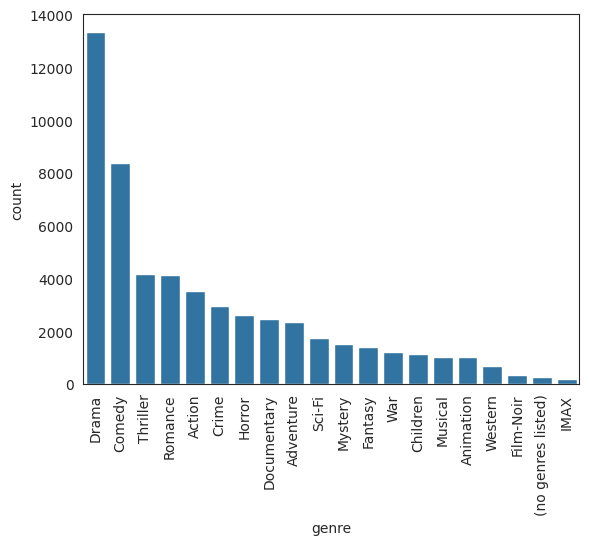

In [ ]:
gen_f_df = pd.DataFrame([gen_f]).T.reset_index()
gen_f_df.columns = ['genre', 'count']

sns.barplot(x='genre', y='count', data=gen_f_df.sort_values(by='count', ascending=False))
plt.xticks(rotation=90)
plt.show()

# Model

Train test split using leave one out method

In [ ]:
!pip install pytorch_lightning

In [ ]:

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

np.random.seed(123)

In [ ]:
ratings_part = ratings.copy()

rand_userIds = np.random.choice(ratings_part['userId'].unique(),
                                size=int(len(ratings_part['userId'].unique())*0.005),
                                replace=False)

ratings_part = ratings_part.loc[ratings_part['userId'].isin(rand_userIds)]

print('There are {} rows of data from {} users'.format(len(ratings_part), len(rand_userIds)))

There are 109185 rows of data from 692 users


In [ ]:
ratings_part['rank_latest'] = ratings_part.groupby(['userId'])['timestamp'] \
                                .rank(method='first', ascending=False)

train_ratings = ratings_part[ratings_part['rank_latest'] != 1]
test_ratings = ratings_part[ratings_part['rank_latest'] == 1]

# drop columns that we no longer need
train_ratings = train_ratings[['userId', 'movieId', 'rating']]
test_ratings = test_ratings[['userId', 'movieId', 'rating']]

In [ ]:
train_ratings.sample(5)

,userId,movieId,rating
4863839,33402,3713,4.0
14947956,103231,1328,5.0
14350177,99154,3996,4.0
1451570,9815,200,3.0
15243756,105370,204,1.5


In [ ]:
# train_ratings.loc[:, 'rating'] = 1

# train_ratings.sample(5)

,userId,movieId,rating
350181,2367,586,1.0
15857510,109710,1580,1.0
12233228,84497,1732,1.0
4923440,33863,2043,1.0
7887633,54368,1196,1.0


In [ ]:
# Get a list of all movie IDs
all_movieIds = ratings['movieId'].unique()

# Placeholders that will hold the training data
users, items, labels = [], [], []

# This is the set of items that each user has interaction with
user_item_set = set(zip(train_ratings['userId'], train_ratings['movieId']))

# 4:1 ratio of negative to positive samples
num_negatives = 4

for (u, i) in tqdm(user_item_set):
    users.append(u)
    items.append(i)
    labels.append(1) # items that the user has interacted with are positive
    for _ in range(num_negatives):
        # randomly select an item
        negative_item = np.random.choice(all_movieIds)
        # check that the user has not interacted with this item
        while (u, negative_item) in user_item_set:
            negative_item = np.random.choice(all_movieIds)
        users.append(u)
        items.append(negative_item)
        labels.append(0) # items not interacted with are negative

  0%|          | 0/108493 [00:00<?, ?it/s]

In [ ]:
class MovieLensTrainDataset(Dataset):
    """MovieLens PyTorch Dataset for Training

    Args:
        ratings (pd.DataFrame): Dataframe containing the movie ratings
        all_movieIds (list): List containing all movieIds

    """

    def __init__(self, ratings, all_movieIds):
        self.users, self.items, self.labels = self.get_dataset(ratings, all_movieIds)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

    def get_dataset(self, ratings, all_movieIds):
        users, items, labels = [], [], []
        user_item_set = set(zip(ratings['userId'], ratings['movieId']))

        num_negatives = 4
        for u, i in user_item_set:
            users.append(u)
            items.append(i)
            labels.append(1)
            for _ in range(num_negatives):
                negative_item = np.random.choice(all_movieIds)
                while (u, negative_item) in user_item_set:
                    negative_item = np.random.choice(all_movieIds)
                users.append(u)
                items.append(negative_item)
                labels.append(0)

        return torch.tensor(users), torch.tensor(items), torch.tensor(labels)

In [ ]:
class NCF(pl.LightningModule):
    """ Neural Collaborative Filtering (NCF)

        Args:
            num_users (int): Number of unique users
            num_items (int): Number of unique items
            ratings (pd.DataFrame): Dataframe containing the movie ratings for training
            all_movieIds (list): List containing all movieIds (train + test)
    """

    def __init__(self, num_users, num_items, ratings, all_movieIds):
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=8)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=8)
        self.fc1 = nn.Linear(in_features=16, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)
        self.ratings = ratings
        self.all_movieIds = all_movieIds

    def forward(self, user_input, item_input):

        # Pass through embedding layers
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)

        # Concat the two embedding layers
        vector = torch.cat([user_embedded, item_embedded], dim=-1)

        # Pass through dense layer
        vector = nn.ReLU()(self.fc1(vector))
        vector = nn.ReLU()(self.fc2(vector))

        # Output layer
        pred = nn.Sigmoid()(self.output(vector))

        return pred

    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return DataLoader(MovieLensTrainDataset(self.ratings, self.all_movieIds),
                          batch_size=512, num_workers=4)

In [ ]:
num_users = ratings['userId'].max()+1
num_items = ratings['movieId'].max()+1

all_movieIds = ratings['movieId'].unique()

model = NCF(num_users, num_items, train_ratings, all_movieIds)

In [ ]:
trainer = pl.Trainer(max_epochs=5, devices=1, accelerator='auto', reload_dataloaders_every_n_epochs=1,
                     logger=False, enable_checkpointing=False)

trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: True, using: 1 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 1.1 M 
1 | item_embedding | Embedding | 1.1 M 
2 | fc1            | Linear    | 1.1 K 
3 | fc2            | Linear    | 2.1 K 
4 | output         | Linear    | 33    
---------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.645     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
# User-item pairs for testing
test_user_item_set = set(zip(test_ratings['userId'], test_ratings['movieId']))

# Dict of all items that are interacted with by each user
user_interacted_items = ratings.groupby('userId')['movieId'].apply(list).to_dict()

hits = []
for (u,i) in tqdm(test_user_item_set):
    interacted_items = user_interacted_items[u]
    not_interacted_items = set(all_movieIds) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]

    predicted_labels = np.squeeze(model(torch.tensor([u]*100),
                                        torch.tensor(test_items)).detach().numpy())

    top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]

    if i in top10_items:
        hits.append(1)
    else:
        hits.append(0)

print("The Hit Ratio @ 10 is {:.2f}".format(np.average(hits)))

  0%|          | 0/692 [00:00<?, ?it/s]

The Hit Ratio @ 10 is 0.84
